In [ ]:
import gcm_filters
import intake
import hvplot.xarray
import numpy as np
import geoviews as gv
from cartopy import crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import dask

gv.extension('bokeh')

In [2]:
cat = intake.open_catalog('../catalog/intake.yaml')

In [3]:
ds = cat.Himawari_SST_L3C_1d_ngt.to_dask()

In [4]:
ds_august_kimberley = ds.sel(time=slice('2022-08-01',None),lat=slice(-13,-18),lon=slice(118,127))

In [ ]:
cloud_free = ds_august_kimberley.sea_surface_temperature.sel(time='2022-08-13 19:00:00').load()
cloud_free.hvplot(cmap='magma',crs=ccrs.PlateCarree())

In [6]:
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

In [7]:
wet_mask = 1-np.isnan(cloud_free).astype(int)

# Add a little mask boundary around the outside to reduce edge effects
max_scale=16
boundary = xr.ones_like(wet_mask)
boundary[0:max_scale,:]=0
boundary[-max_scale:,:]=0
boundary[:,0:max_scale]=0
boundary[:,-max_scale:]=0
wet_mask = wet_mask * boundary

In [8]:
dx = 0.02
a = 6378.137
e = 1-6356.752**2/a**2
r = np.pi/180
area = (a*r*dx)**2*(1-e)*np.cos(r*cloud_free.lat)/(1-e*np.sin(r*cloud_free.lat)**2)**2
area = area.broadcast_like(cloud_free)
area

<xarray.DataArray 'lat' (lat: 250, lon: 450)>
array([[4.8004994, 4.8004994, 4.8004994, ..., 4.8004994, 4.8004994,
        4.8004994],
       [4.800122 , 4.800122 , 4.800122 , ..., 4.800122 , 4.800122 ,
        4.800122 ],
       [4.799744 , 4.799744 , 4.799744 , ..., 4.799744 , 4.799744 ,
        4.799744 ],
       ...,
       [4.689937 , 4.689937 , 4.689937 , ..., 4.689937 , 4.689937 ,
        4.689937 ],
       [4.6894197, 4.6894197, 4.6894197, ..., 4.6894197, 4.6894197,
        4.6894197],
       [4.688901 , 4.688901 , 4.688901 , ..., 4.688901 , 4.688901 ,
        4.688901 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -13.01 -13.03 -13.05 -13.07 ... -17.95 -17.97 -17.99
    time     datetime64[ns] 2022-08-13T19:00:00
  * lon      (lon) float32 118.0 118.0 118.1 118.1 ... 126.9 126.9 127.0 127.0

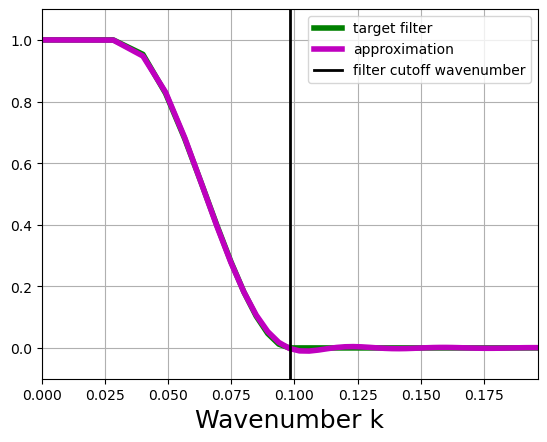

In [9]:
filter = gcm_filters.Filter(
    filter_scale=64,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'wet_mask': wet_mask, 'area':area}
)
filter.plot_shape()

In [10]:
filtered_sst = filter.apply(cloud_free, dims=['lat', 'lon']).compute()

In [ ]:
%%opts Image [width=900 height=600]
filtered_sst.hvplot(cmap='magma',crs=ccrs.PlateCarree())

In [ ]:
%%opts Image [width=900 height=600]
(cloud_free - filtered_sst).rename('highpass').hvplot(cmap='RdBu',crs=ccrs.PlateCarree()).redim(highpass=dict(range=(-0.5, 0.5)))

# Build a bank of non-overlapping filters

There is a bit of ripple in these, but they are much sharper at separating the scales

(0.0, 3.0)

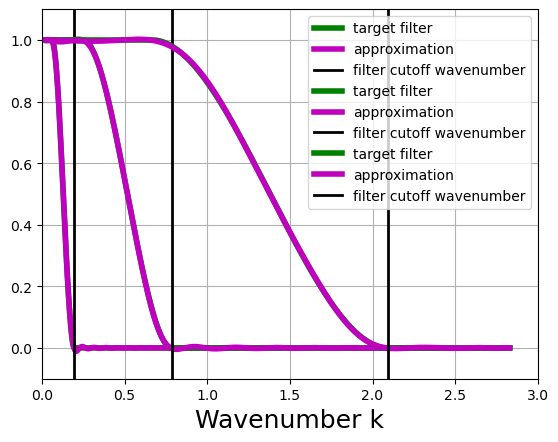

In [13]:
filter_bank = {}
scales = [32, 8, 3]
fig,ax = plt.subplots()
for i,s in enumerate(scales):
    filter = gcm_filters.Filter(
            filter_scale=s,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
            grid_vars={'wet_mask': wet_mask, 'area':area})
    filter.plot_shape(ax=ax)
    filter_bank[s] = filter
    
ax.set_xlim(0,3)

# Test on timeseries

In [14]:
timeseries = ds_august_kimberley.sea_surface_temperature.sel(time='2022-08')
timeseries = timeseries - timeseries.mean(dim='time')
wet_mask = 1-np.isnan(timeseries).astype(int)
wet_mask = wet_mask * boundary

In [15]:
band_passed = []
high_pass = None
for s,filter in filter_bank.items():
    if high_pass is None:
        low_pass = filter.apply(timeseries, dims=['lat', 'lon'])
        high_pass = timeseries - low_pass
    else:
        low_pass = filter.apply(high_pass, dims=['lat', 'lon'])
        high_pass = high_pass - low_pass
    band_passed.append(low_pass)
# Append a 'scale' for the residual
band_passed.append(high_pass)

In [ ]:
band_passed_ds = xr.concat(band_passed, dim=xr.DataArray(scales + [0,],name='scale',dims=['scale',]))
band_passed_ds

In [17]:
band_passed_ds.nbytes/1E6

729.0

# Start a dask cluster for calculation

In [18]:
def get_distributed_cluster(conda_environment='pbranson/gcm-filters-env', profile='Medium Worker', min_workers=1, max_workers=20):
    from dask.distributed import Client
    from dask_gateway import Gateway
    
    # Dask gateway
    gateway = Gateway()
    clusters = gateway.list_clusters()
    if not clusters:
        print('Creating new cluster. Please wait for this to finish.')
        options = gateway.cluster_options()
        options.conda_environment = conda_environment
        options.profile = profile
        cluster = gateway.new_cluster(cluster_options=options)
    else:
        print(f'An existing cluster was found. Connected to cluster \033[1m{clusters[0].name}\033[0m')
        cluster=gateway.connect(clusters[0].name)
    cluster.adapt(minimum=min_workers, maximum=max_workers)
    client = cluster.get_client()
    client.wait_for_workers(n_workers=1)
    display(cluster)
    return client
client = get_distributed_cluster()

An existing cluster was found. Connected to cluster dev.8a2ed09fb8134696b4211e06f27cc159


In [19]:
band_passed_ds_masked = band_passed_ds.where(boundary.astype(bool),np.nan)
band_passed_ds_masked = band_passed_ds_masked.compute()

In [ ]:
%%opts Image [width=900 height=500]
band_passed_ds_masked.rename('temp_variance').hvplot('lon','lat',dynamic=True,cmap='RdBu',crs=ccrs.PlateCarree()).redim(temp_variance=dict(range=(-0.5, 0.5)))

In [ ]:
mean = band_passed_ds_masked.mean(dim=['lon','lat']).compute()
var = band_passed_ds_masked.var(dim=['lon','lat']).compute()
cloudiness = wet_mask.sum(dim=['lon','lat']).compute()

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(8,6),sharex=True)
mean.plot(ax=axs[0],hue='scale')
var.plot(ax=axs[1],hue='scale')
cloudiness.plot(ax=axs[2])

for i,l in enumerate(['Mean','Variance','Cloudiness/Wet Pixels']):
    axs[i].set_ylabel(l)

In [ ]:
cloudiness.hvplot()

# Expand the calculation and filter out the cloudy scenes

In [22]:
client.cluster.scale(20)

In [23]:
timeseries = ds.sea_surface_temperature.sel(time=slice('2021-04','2022-08'),lat=slice(-13,-18),lon=slice(118,127))
timeseries.nbytes/1E9

5.31855

In [24]:
wet_mask = 1-np.isnan(timeseries).astype(int)
wet_mask = wet_mask * boundary
time_inds = wet_mask.sum(dim=['lon','lat']) > 64000

In [25]:
time_inds = time_inds.compute()

In [ ]:
cloud_free = timeseries.isel(time=time_inds)
cloud_free

In [27]:
cloud_free = cloud_free - cloud_free.mean(dim='time')
wet_mask = 1-np.isnan(cloud_free).astype(int)
wet_mask = wet_mask * boundary

In [ ]:
band_passed = []
high_pass = None
for s,filter in filter_bank.items():
    if high_pass is None:
        low_pass = filter.apply(cloud_free, dims=['lat', 'lon'])
        high_pass = cloud_free - low_pass
    else:
        low_pass = filter.apply(high_pass, dims=['lat', 'lon'])
        high_pass = high_pass - low_pass
    band_passed.append(low_pass)

band_passed.append(high_pass)
band_passed_ds = xr.concat(band_passed, dim=xr.DataArray(scales + [0,],name='scale',dims=['scale',]))
band_passed_ds_masked = band_passed_ds.where(boundary.astype(bool),np.nan)
band_passed_ds_masked

In [29]:
results_ds = xr.Dataset()
results_ds['mean'] = band_passed_ds_masked.mean(dim=['lon','lat'])
results_ds['var'] = band_passed_ds_masked.var(dim=['lon','lat'])
results_ds['cloudiness'] = wet_mask.sum(dim=['lon','lat'])

In [ ]:
results_ds

In [31]:
results_ds = results_ds.compute()

In [ ]:
import holoviews as hv
hv.extension('matplotlib')

In [ ]:
(results_ds['mean'].hvplot.scatter(x='time',by='scale').opts(width=900) + results_ds['var'].hvplot.scatter(x='time',by='scale').opts(width=900)).cols(1)

In [ ]:
client.cluster.shutdown()

# TODO: Next Steps

1. Masking the clouds as land works pretty well, however there are small artifacts at the boundaries. Dilating the masks a few pixels could work to filter these artifacts
2. Apply QC flags
3. Need to consider the appropriate spatial scales for the filters
4. Timeseries analysis of the variance and limiting to night time only to try isolate tidal modulation. Also refinement of AOI